# H2O Sonar Model Validation Explainers

This example demonstrates explainers that are based on [H2O Model Validation](https://github.com/h2oai/model-validation) (MV) tests:

* Adversarial Similarity explainer
* Backtesting explainer
* Calibration Score explainer
* Drift Detection explainer
* Segment Performance explainer
* Size Dependency explainer

Please see H2O Model Validation [documentation](https://docs.h2o.ai/wave-apps/h2o-model-validation/) for MV tests features, purpose and use.

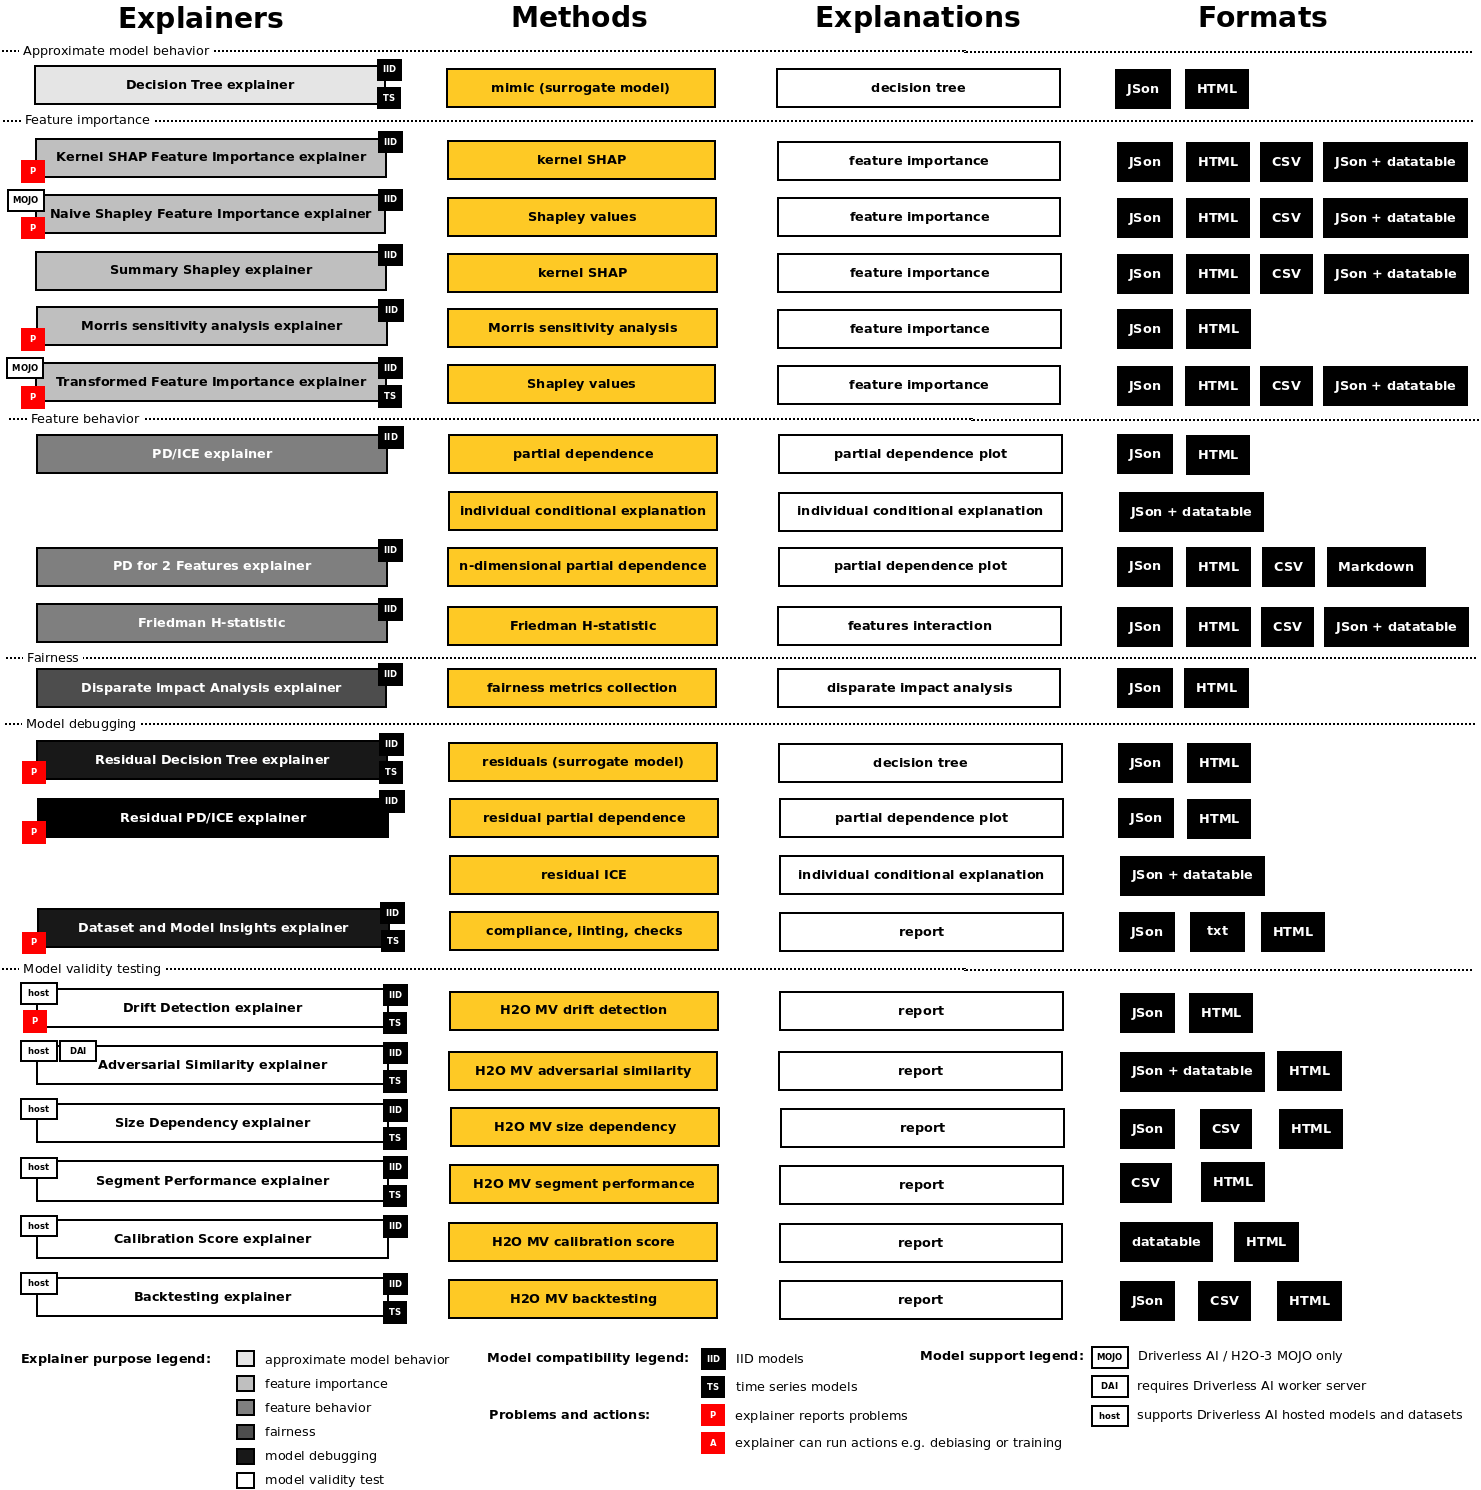

In [1]:
from IPython.display import Image
Image(filename='../../docs/source/images/explainers-overview.png')

**Table of Contents**

* Pre-requisites 
  * Driverless AI Connections Configuration
  * Driverless AI Experiments Preparation
* Interpretation: Python API
   * Drift Detection explainer
   * H2O Model Validation explainers that use Driverless AI (regression)
   * Calibration Score explainer (classification)
* Interpretation: CLI
   * Drift Detection explainer
   * H2O Model Validation explainers that use Driverless AI (regression


# Pre-requisites

In [2]:
import json
import os

import datatable
import webbrowser

from h2o_sonar import config as h2o_sonar_config
from h2o_sonar import interpret
from h2o_sonar.lib.api import commons
from h2o_sonar.lib.api import explainers

import warnings
warnings.filterwarnings('ignore')

In [3]:
from h2o_sonar.explainers.drift_explainer import DriftDetectionExplainer
from h2o_sonar.explainers.adversarial_similarity_explainer import AdversarialSimilarityExplainer
from h2o_sonar.explainers.size_dependency_explainer import SizeDependencyExplainer
from h2o_sonar.explainers.segment_performance_explainer import SegmentPerformanceExplainer
from h2o_sonar.explainers.calibration_score_explainer import CalibrationScoreExplainer
from h2o_sonar.explainers.backtesting_explainer import BacktestingExplainer

## Configuration

Certain MV-based explainers require Driverless AI connection and/or Driverless autoML connection (see the documentation). Driverless AI connection must be configured prior running the interpretation:

In [4]:
# CHOSE and UPDATE one of the Driverless AI server options:

# OPTION: H2O AIEM hosted Driverless AI
AIEM_DAI_WORKER_CONNECTION = h2o_sonar_config.ConnectionConfig(
    connection_type=h2o_sonar_config.ConnectionConfigType.DRIVERLESS_AI_AIEM.name,
    name="My H2O AIEM hosted Driverless AI ",
    description="Driverless AI server hosted by H2O Enterprise AIEM.",
    # H2O AIEM server URL
    server_url="https://enginemanager.cloud.h2o.ai/",
    # name of the Driverless AI server in H2O AIEM
    server_id="new-dai-engine-42",
    # H2O.ai environment URL
    environment_url="https://cloud.h2o.ai",
    # valid H2O.ai Cloud user name
    username="firstname.lastname@h2o.ai",
    # H2O.ai refresh token for given environment which might be obtained from:
    # H2O.ai Cloud > User > CLI & API Access > API Token (generation)
    token=os.getenv("H2O_SONAR_AIEM_REFRESH_TOKEN_CLOUD_QA"),
    # REFRESH_TOKEN as token use type
    token_use_type=h2o_sonar_config.TokenUseType.REFRESH_TOKEN.name,
)

# OPTION: H2O Enterprise Steam hosted Driverless AI
STEAM_DAI_WORKER_CONNECTION = h2o_sonar_config.ConnectionConfig(
    connection_type=h2o_sonar_config.ConnectionConfigType.DRIVERLESS_AI_STEAM.name,
    name="My H2O Steam hosted Driverless AI ",
    description="Driverless AI server hosted by H2O Enterprise Steam.",
    # name of the Driverless AI server in H2O Enterprise Steam
    server_id="my-demo-driverless-ai",
    # H2O Enterprise Steam server URL
    server_url="https://steam.cloud.h2o.ai/",
    # username (needed by MV, but actually overwritten after contacting Steam)
    username="firstname.lastname@h2o.ai",
    # H2O Enterprise Steam client access token which might be obtained from:
    # Enterprise Steam > Configurations > Personal Access Token > Get token
    token=os.getenv("H2O_SONAR_STEAM_TOKEN_CLOUD"),
    # ACCESS_TOKEN as token use type
    token_use_type=h2o_sonar_config.TokenUseType.ACCESS_TOKEN.name,
)

# OPTION: local/private Driverless AI installation
LOCAL_DAI_WORKER_CONNECTION = h2o_sonar_config.ConnectionConfig(
    connection_type=h2o_sonar_config.ConnectionConfigType.DRIVERLESS_AI.name,
    name="Local Driverless AI server",
    description="Driverless AI server running on the localhost.",
    server_url="http://localhost:12345",
    username="h2oai",
    password="h2oai",
)

# MAKE YOUR CHOICE fro one of the options above:
DAI_WORKER_CONNECTION=LOCAL_DAI_WORKER_CONNECTION

In [5]:
# add Driverless AI connection to the H2O Sonar configuration
h2o_sonar_config.config.add_connection(DAI_WORKER_CONNECTION)

In [6]:
h2o_sonar_config.config.to_dict(encrypt=False)

{'h2o_host': 'localhost',
 'h2o_port': 12349,
 'h2o_auto_start': True,
 'h2o_min_mem_size': '2G',
 'h2o_max_mem_size': '4G',
 'custom_explainers': [],
 'look_and_feel': 'h2o_sonar',
 'per_explainer_logger': True,
 'create_html_representations': True,
 'connections': [{'key': '0d860575-9d4b-46e5-9870-97ebd73780a1',
   'connection_type': 'DRIVERLESS_AI',
   'name': 'Local Driverless AI server',
   'description': 'Driverless AI server running on the localhost.',
   'auth_server_url': '',
   'environment_url': '',
   'server_url': 'http://localhost:12345',
   'server_id': '',
   'realm_name': '',
   'client_id': '',
   'token': '',
   'token_use_type': '',
   'username': 'h2oai',
   'password': 'h2oai'}],
 'licenses': []}

## Driverless AI Experiments

Prepare time series and multinomial Driverless AI experiments from below to be 
EXPLAINED by H2O Model Validation based explainers provided by H2O Sonar.

In [7]:
# TIME SERIES Driverless AI experiment
#
# 1) create a time series experiment in Driverless AI to build the model to be EXPLAINED, for example:
#    train dataset: walmart_tts_small_train.csv
#    test dataset : walmart_tts_small_test.csv
#    target column: Weekly_Sales
#    time_col     : Date
# 2) set UUIDs of the Driverless AI experiment and dataset(s):
ts_model_uuid = "b78cb888-f658-11ed-9ecf-0242709d15f7"
ts_dataset_uuid = "a407dd4c-f658-11ed-9ecf-0242709d15f7"
ts_testset_uuid = "a4077500-f658-11ed-9ecf-0242709d15f7"
ts_target_col = "Weekly_Sales"
ts_time_col = "Date"

# 2) use HANDLERs to reference ^ datasets and model to be explained
ts_model_handle = commons.ResourceHandle(
    connection_key=DAI_WORKER_CONNECTION.key,
    resource_key=ts_model_uuid,
)
ts_dataset_handle = commons.ResourceHandle(
    connection_key=DAI_WORKER_CONNECTION.key,
    resource_key=ts_dataset_uuid,
)
ts_testset_handle = commons.ResourceHandle(
    connection_key=DAI_WORKER_CONNECTION.key,
    resource_key=ts_testset_uuid,
)

In [9]:
# MULTINOMIAL Driverless AI experiment

# 1) create a multinomial experiment in Driverless AI to build the model to be EXPLAINED, for example:
#    train dataset: creditcard.csv
#    target column: EDUCATION
# 2) set UUIDs of the Driverless AI experiment and dataset(s):
m_model_uuid = "4b000748-fba7-11ed-8ea4-8c1d96f410ff"
m_dataset_uuid = "f330f964-ab83-11ed-aa8e-a0cec818dc16"
m_target_col = "EDUCATION"

# 2) use HANDLERs to reference ^ datasets and model to be explained
m_model_handle = commons.ResourceHandle(
    connection_key=DAI_WORKER_CONNECTION.key,
    resource_key=m_model_uuid,
)
m_dataset_handle = commons.ResourceHandle(
    connection_key=DAI_WORKER_CONNECTION.key,
    resource_key=m_dataset_uuid,
)

## Interpretation: Python API

Lets run MV test explainers using the H2O Sonar's Python API.

In [11]:
# list H2O Model Validation explainers
mv_explainers = [e.id for e in interpret.list_explainers() if "h2o-model-validation" in e.keywords]
mv_explainers

['h2o_sonar.explainers.drift_explainer.DriftDetectionExplainer',
 'h2o_sonar.explainers.adversarial_similarity_explainer.AdversarialSimilarityExplainer',
 'h2o_sonar.explainers.size_dependency_explainer.SizeDependencyExplainer',
 'h2o_sonar.explainers.segment_performance_explainer.SegmentPerformanceExplainer',
 'h2o_sonar.explainers.calibration_score_explainer.CalibrationScoreExplainer',
 'h2o_sonar.explainers.backtesting_explainer.BacktestingExplainer']

In [12]:
# get explainer name, description, parameters, keywords, ...
interpret.describe_explainer(mv_explainers[0])

{'id': 'h2o_sonar.explainers.drift_explainer.DriftDetectionExplainer',
 'name': 'DriftDetectionExplainer',
 'display_name': 'Drift Detection',
 'description': "Drift detection refers to a validation test that enables you to identifychanges in the distribution of variables in your model's input data, preventing model performance degradation. The explainer performs drift detection using the train and another dataset captured at different times to assess how data has changed over time. The Population Stability Index (PSI) formula is applied to each variable to measure how much the variable has shifted in distribution over time. PSI is applied to numerical and categorical columns and not date columns.",
 'model_types': ['iid', 'time_series'],
 'can_explain': ['regression', 'binomial', 'multinomial'],
 'explanation_scopes': ['global_scope'],
 'explanations': [{'explanation_type': 'global-work-dir-archive',
   'name': 'WorkDirArchiveExplanation',
   'category': None,
   'scope': 'global',
  

## Run Drift Detection explainer

Lets run Drift explainer - which requires two (local or remote) datasets, but does **not** need model.

In [13]:
# prepare PRIMARY DATASET
primary_dataset_path = "../../data/creditcard.csv"

# prepare SECONDARY DATASET (just randomize/sub-set primary dataset for the DEMO purpose)
secondary_dataset = datatable.fread(primary_dataset_path)[:500, :]
secondary_dataset_path = str("/tmp/secondary_dataset.csv")
secondary_dataset.to_csv(secondary_dataset_path)

In [14]:
# run the interpretation
interpretation = interpret.run_interpretation(
    dataset=primary_dataset_path,
    testset=secondary_dataset_path,
    model=None,
    target_col="default payment next month",
    explainers=[DriftDetectionExplainer.explainer_id()],
    results_location="results-drift",
)

2023/09/26 17:33:16 # DEBUG H2O Model Validation LogLevel: DEBUG - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/logging.py:97
2023/09/26 17:33:17 # WARNING IoC/DI: No implementations found for >>IMVDatabase<< - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/ioc.py:35
2023/09/26 17:33:17 # ERROR Can't save test Drift Detection: no database connection - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:529
2023/09/26 17:33:17 # DEBUG Selected database: test-db - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:255
2023/09/26 17:33:17 # INFO Initialize MVDatabase: test-db
2023/09/26 17:33:17 # DEBUG SQLDatabase: results-drift/h2o-sonar/mli_experiment_ea02c00c-8cb5-4596-bde0-1d602a862c1e/tmp/test.sql_db.sqlite - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:187
2023/09/26 17:33:17 # DEBUG ObjectStorage:

In [15]:
# get Drift Detection explainer result
drift_result = interpretation.get_explainer_result(
    DriftDetectionExplainer.explainer_id()
)

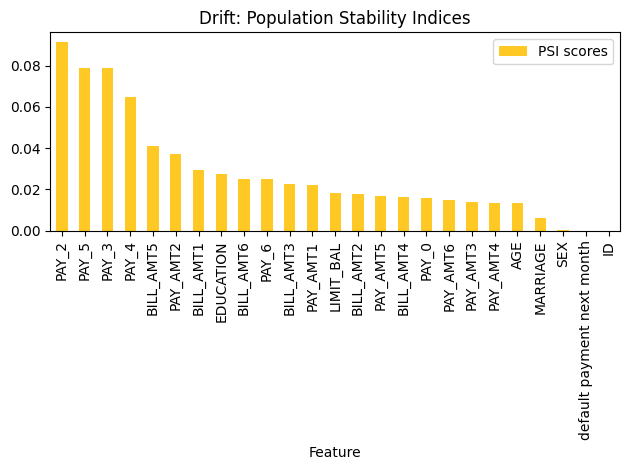

In [16]:
drift_result.plot()

In [17]:
drift_result.data()

<Frame#7f736f43b5a0 25x2>

In [18]:
# summary
drift_result.summary()

{'id': 'h2o_sonar.explainers.drift_explainer.DriftDetectionExplainer',
 'name': 'DriftDetectionExplainer',
 'display_name': 'Drift Detection',
 'description': "Drift detection refers to a validation test that enables you to identifychanges in the distribution of variables in your model's input data, preventing model performance degradation. The explainer performs drift detection using the train and another dataset captured at different times to assess how data has changed over time. The Population Stability Index (PSI) formula is applied to each variable to measure how much the variable has shifted in distribution over time. PSI is applied to numerical and categorical columns and not date columns.",
 'model_types': ['iid', 'time_series'],
 'can_explain': ['regression', 'binomial', 'multinomial'],
 'explanation_scopes': ['global_scope'],
 'explanations': [{'explanation_type': 'global-feature-importance',
   'name': 'DriftDetectionExplainer',
   'category': 'COMPLIANCE TESTS',
   'scope'

In [19]:
# open interpretation HTML report in web browser
webbrowser.open(interpretation.result.get_html_report_location())

True

In [20]:
# save the explainer result as zip archive
drift_result.zip(file_path="./drift-detection-demo-archive.zip")

In [21]:
!unzip -l drift-detection-demo-archive.zip

Archive:  drift-detection-demo-archive.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     3757  2023-09-26 17:33   explainer_h2o_sonar_explainers_drift_explainer_DriftDetectionExplainer_dfff02c1-2007-4b47-a6fa-70d4013b42f4/result_descriptor.json
      110  2023-09-26 17:33   explainer_h2o_sonar_explainers_drift_explainer_DriftDetectionExplainer_dfff02c1-2007-4b47-a6fa-70d4013b42f4/global_html_fragment/text_html.meta
      358  2023-09-26 17:33   explainer_h2o_sonar_explainers_drift_explainer_DriftDetectionExplainer_dfff02c1-2007-4b47-a6fa-70d4013b42f4/global_html_fragment/text_html/explanation.html
    30716  2023-09-26 17:33   explainer_h2o_sonar_explainers_drift_explainer_DriftDetectionExplainer_dfff02c1-2007-4b47-a6fa-70d4013b42f4/global_html_fragment/text_html/fi-class-0.png
      164  2023-09-26 17:33   explainer_h2o_sonar_explainers_drift_explainer_DriftDetectionExplainer_dfff02c1-2007-4b47-a6fa-70d4013b42f4/global_model_validation_result/application_z

## Run Adversarial Similarity explainer

Adversarial Similarity explainer can use remote Driverless AI worker to explain local datasets.

In [22]:
# run the interpretation
interpretation = interpret.run_interpretation(
    dataset=primary_dataset_path,
    testset=secondary_dataset_path,
    model=None,
    target_col="default payment next month",
    explainers = [
        commons.ExplainerToRun(
            explainer_id=AdversarialSimilarityExplainer.explainer_id(),
            params={
                AdversarialSimilarityExplainer.PARAM_WORKER: DAI_WORKER_CONNECTION.key,
            },
        ),
    ],
    results_location="results-adversarial",
)

2023/09/26 17:33:44 # DEBUG Save Adversarial Similarity: Adversarial Similarity - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:33:44 # WARNING Singleton MVClient already initialized, ignoring: args=(), kwargs={'data_folder': 'results-adversarial/h2o-sonar/mli_experiment_c9e66eb3-3deb-4a2c-9785-2d95ff2f38fb/tmp'} - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:296
2023/09/26 17:33:44 # DEBUG Selected database: test-db - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:255
2023/09/26 17:33:44 # INFO Initialize MVDatabase: test-db
2023/09/26 17:33:44 # DEBUG SQLDatabase: results-drift/h2o-sonar/mli_experiment_ea02c00c-8cb5-4596-bde0-1d602a862c1e/tmp/test.sql_db.sqlite - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:187
2023/09/26 17:33:44 # DEBUG ObjectStorage: results-drift/h2o-sonar/mli_experimen

A service ('Driverless AI') is running on localhost:12345 and it is accessible


2023/09/26 17:33:44 # INFO Adding connection to Driverless AI server 'http://localhost:12345' for user 'h2oai'
2023/09/26 17:33:44 # DEBUG Save credentials: DriverlessCredentials(address='http://localhost:12345', username='h2oai') - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_cache.py:33
2023/09/26 17:33:46 # DEBUG Worker set: <h2o_mv.platforms.driverless.platform.DriverlessPlatform object at 0x7f73b36a0250> - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:331
2023/09/26 17:33:46 # DEBUG Dataset with hash 3c4c14a0ee50160d already stored in LocalPlatform - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/local/platform.py:113
2023/09/26 17:33:46 # DEBUG Import dataset obj-3a12f131-56e4-4ecc-b26f-a4bd5aae8ddc from LocalPlatform - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/local/platform.py:64
2023/09/26 17:33:46 # DEBUG Dataset wit

Complete 100.00% - [4/4] Computed stats for column BILL_AMT6
INFO - Experiment launched at: http://localhost:12345/#/experiment?key=171de292-5c82-11ee-9192-00e04c68003f


2023/09/26 17:36:41 # INFO Adversarial Similarity 'Adversarial Similarity': Processing results
2023/09/26 17:36:41 # DEBUG Folder data/temp/7a52a2bd-13d0-4a55-8237/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/7a52a2bd-13d0-4a55-8237/train_preds_train.csv'


2023/09/26 17:36:42 # DEBUG Folder data/temp/7a52a2bd-13d0-4a55-8237/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:36:42 # DEBUG Folder data/temp/2ab76e11-e81b-4736-a2e7/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/2ab76e11-e81b-4736-a2e7/h2oai_experiment_summary_171de292-5c82-11ee-9192-00e04c68003f.zip'


2023/09/26 17:36:42 # DEBUG Folder data/temp/2ab76e11-e81b-4736-a2e7/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:36:42 # INFO Adversarial Similarity 'Adversarial Similarity': Completed
2023/09/26 17:36:42 # DEBUG Save Adversarial Similarity: Adversarial Similarity - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:36:43 # DEBUG Worker cleanup - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:801
2023/09/26 17:36:43 # DEBUG Deleting temporary experiment 171de292-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:803


INFO - Driverless AI Server reported experiment 171de292-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:36:44 # DEBUG Deleting temporary dataset 162c074c-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset 162c074c-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:36:44 # DEBUG Folder data/temp/mvt-4c3821f7-7468-454b-bf32-0ede503ca1ca/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:36:44 # DEBUG Folder data/artifacts/mvt-4c3821f7-7468-454b-bf32-0ede503ca1ca/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227


In [23]:
result = interpretation.get_explainer_result(
    AdversarialSimilarityExplainer.explainer_id()
)

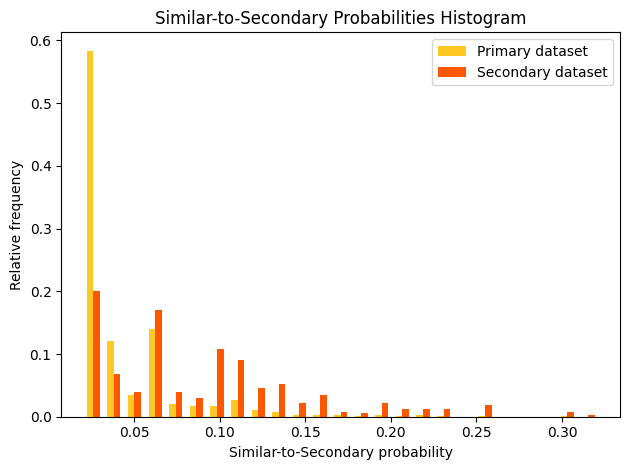

In [24]:
result.plot()

In [25]:
result.data()

<Frame#7f7320a0e4e0 25x3>

## Run H2O Model Validation explainers which use Driverless AI server

Lets run a few H2O Model Validation based explainers which explain **remote** models and datasets hosted by a Driverless AI server.

In [26]:
# list H2O Model Validation explainers
all_mv_explainers = [e.id for e in interpret.list_explainers() if "h2o-model-validation" in e.keywords]
all_mv_explainers

['h2o_sonar.explainers.drift_explainer.DriftDetectionExplainer',
 'h2o_sonar.explainers.adversarial_similarity_explainer.AdversarialSimilarityExplainer',
 'h2o_sonar.explainers.size_dependency_explainer.SizeDependencyExplainer',
 'h2o_sonar.explainers.segment_performance_explainer.SegmentPerformanceExplainer',
 'h2o_sonar.explainers.calibration_score_explainer.CalibrationScoreExplainer',
 'h2o_sonar.explainers.backtesting_explainer.BacktestingExplainer']

In [27]:
# (model) handle is a string that identifies REMOTE model in the H2O Sonar runtime
str(ts_model_handle)

'resource:connection:0d860575-9d4b-46e5-9870-97ebd73780a1:key:b78cb888-f658-11ed-9ecf-0242709d15f7'

In [28]:
str(ts_dataset_handle)

'resource:connection:0d860575-9d4b-46e5-9870-97ebd73780a1:key:a407dd4c-f658-11ed-9ecf-0242709d15f7'

In [29]:
str(ts_testset_handle)

'resource:connection:0d860575-9d4b-46e5-9870-97ebd73780a1:key:a4077500-f658-11ed-9ecf-0242709d15f7'

In [31]:
DAI_WORKER_CONNECTION.key

'0d860575-9d4b-46e5-9870-97ebd73780a1'

In [32]:
h2o_sonar_config.config.to_dict(encrypt=False)

{'h2o_host': 'localhost',
 'h2o_port': 12349,
 'h2o_auto_start': True,
 'h2o_min_mem_size': '2G',
 'h2o_max_mem_size': '4G',
 'custom_explainers': [],
 'look_and_feel': 'h2o_sonar',
 'per_explainer_logger': True,
 'create_html_representations': True,
 'connections': [{'key': '0d860575-9d4b-46e5-9870-97ebd73780a1',
   'connection_type': 'DRIVERLESS_AI',
   'name': 'Local Driverless AI server',
   'description': 'Driverless AI server running on the localhost.',
   'auth_server_url': '',
   'environment_url': '',
   'server_url': 'http://localhost:12345',
   'server_id': '',
   'realm_name': '',
   'client_id': '',
   'token': '',
   'token_use_type': '',
   'username': 'h2oai',
   'password': 'h2oai'}],
 'licenses': []}

In [33]:
# run explainers that support REMOTE datasets / models in order to explain a regression experiment
interpretation = interpret.run_interpretation(
    dataset=ts_dataset_handle,
    testset=ts_testset_handle,
    model=ts_model_handle,
    target_col=ts_target_col,
    # schedule for run all MV explainers + specify parameters they need
    explainers=[
        commons.ExplainerToRun(
            explainer_id=BacktestingExplainer.explainer_id(),
            params={
                BacktestingExplainer.PARAM_WORKER: DAI_WORKER_CONNECTION.key,
                BacktestingExplainer.PARAM_TIME_COLUMN: ts_time_col,
            },
        ),
        commons.ExplainerToRun(
            explainer_id=SizeDependencyExplainer.explainer_id(),
            params={
                SizeDependencyExplainer.PARAM_WORKER: DAI_WORKER_CONNECTION.key,
                SizeDependencyExplainer.PARAM_TIME_COLUMN: ts_time_col,
            },
        ),
        commons.ExplainerToRun(
            explainer_id=SegmentPerformanceExplainer.explainer_id(),
            params={
                SegmentPerformanceExplainer.PARAM_WORKER: DAI_WORKER_CONNECTION.key,
            },
        ),        
    ],
    results_location="results-all-mv-explainers",
)

# HINT: Calibration Score explainer will be run later as it requires a CLASSIFICATION experiment

2023/09/26 17:36:45 # DEBUG Save Backtesting: Backtesting - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:36:45 # DEBUG Save Size Dependency: Size Dependency - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:36:45 # DEBUG Save Segment Performance: Segment Performance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:36:45 # WARNING Singleton MVClient already initialized, ignoring: args=(), kwargs={'data_folder': 'results-all-mv-explainers/h2o-sonar/mli_experiment_c292bbf2-8aef-4ee7-86c4-c8c6381f70e9/tmp'} - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:296
2023/09/26 17:36:45 # DEBUG Selected database: test-db - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:255
2023/09/26 17:36:45 # INFO Initialize MVDatabase: test-db
20

A service ('Driverless AI') is running on localhost:12345 and it is accessible
A service ('Driverless AI') is running on localhost:12345 and it is accessible
A service ('Driverless AI') is running on localhost:12345 and it is accessible


2023/09/26 17:36:46 # INFO Adding connection to Driverless AI server 'http://localhost:12345' for user 'h2oai'
2023/09/26 17:36:46 # DEBUG Save credentials: DriverlessCredentials(address='http://localhost:12345', username='h2oai') - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_cache.py:33
2023/09/26 17:36:46 # DEBUG Platform with address 'http://localhost:12345' for user 'h2oai' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:234
2023/09/26 17:36:47 # DEBUG Worker set: <h2o_mv.platforms.driverless.platform.DriverlessPlatform object at 0x7f73cde1d700> - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:331
2023/09/26 17:36:47 # INFO Connection for <class 'h2o_mv.platforms.driverless.platform.DriverlessPlatform'> not supported
2023/09/26 17:36:47 # DEBUG Import dataset a407dd4c-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:1234

INFO - Downloaded 'data/temp/000-walmart_tts_small_train.csv.1684509609.0011456.csv'


2023/09/26 17:36:49 # DEBUG Import experiment b78cb888-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:628
2023/09/26 17:36:49 # DEBUG Import dataset a407dd4c-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_train.csv.1684509609.0011456.csv'


2023/09/26 17:36:51 # DEBUG Dataset with platform_obj_key 'a407dd4c-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:36:51 # DEBUG Import dataset a4077500-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_test.csv.1684509608.881174.csv'


2023/09/26 17:36:52 # DEBUG Folder data/temp/61793d0c-b9ee-4884-94aa/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/61793d0c-b9ee-4884-94aa/h2oai_experiment_summary_b78cb888-f658-11ed-9ecf-0242709d15f7.zip'


2023/09/26 17:36:52 # DEBUG Folder data/temp/61793d0c-b9ee-4884-94aa/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:36:52 # DEBUG Save Backtesting: Backtesting - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:36:52 # DEBUG Folder data/temp/mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69
2023/09/26 17:36:52 # DEBUG Folder data/artifacts/mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:82
2023/09/26 17:36:53 # INFO Backtesting 'Backtesting': Running


INFO - Downloaded 'data/temp/e1b7dfaa-3020-458e-a406.tmp'


2023/09/26 17:36:56 # DEBUG Uploading bt-train:0-mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f to worker instance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:664


Complete 100.00% - [4/4] Computed stats for column sample_weight


2023/09/26 17:36:58 # DEBUG Uploading bt-test:0-mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f to worker instance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:664


Complete 100.00% - [4/4] Computed stats for column sample_weight
INFO - Experiment launched at: http://localhost:12345/#/experiment?key=88d181f0-5c82-11ee-9192-00e04c68003f


2023/09/26 17:37:01 # DEBUG Uploading bt-train:1-mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f to worker instance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:664


Complete 100.00% - [4/4] Computed stats for column sample_weight


2023/09/26 17:37:03 # DEBUG Uploading bt-test:1-mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f to worker instance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:664


Complete 100.00% - [4/4] Computed stats for column sample_weight
INFO - Experiment launched at: http://localhost:12345/#/experiment?key=8c0f9028-5c82-11ee-9192-00e04c68003f


2023/09/26 17:37:41 # INFO Backtesting 'Backtesting': Processing results
2023/09/26 17:37:41 # DEBUG Folder data/temp/8be2e5a2-2323-4cbf-9dea/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/8be2e5a2-2323-4cbf-9dea/h2oai_experiment_summary_8c0f9028-5c82-11ee-9192-00e04c68003f.zip'


2023/09/26 17:37:41 # DEBUG Folder data/temp/8be2e5a2-2323-4cbf-9dea/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:37:41 # INFO Backtesting 'Backtesting': Completed
2023/09/26 17:37:41 # DEBUG Save Backtesting: Backtesting - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:37:41 # DEBUG Worker cleanup - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:801
2023/09/26 17:37:41 # DEBUG Deleting temporary experiment 8c0f9028-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:803


INFO - Driverless AI Server reported experiment 8c0f9028-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:37:43 # DEBUG Deleting temporary experiment 88d181f0-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:803


INFO - Driverless AI Server reported experiment 88d181f0-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:37:44 # DEBUG Deleting temporary dataset 89a7f96a-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset 89a7f96a-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:37:45 # DEBUG Deleting temporary dataset 8b135330-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset 8b135330-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:37:45 # DEBUG Deleting temporary dataset 866ecc1a-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset 866ecc1a-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:37:45 # DEBUG Deleting temporary dataset 87db7e86-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset 87db7e86-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:37:46 # DEBUG Folder data/temp/mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:37:46 # DEBUG Folder data/artifacts/mvt-611575f1-cf5b-4fc9-a0ff-5685538ed42f/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:37:47 # WARNING Singleton MVClient already initialized, ignoring: args=(), kwargs={'data_folder': 'results-all-mv-explainers/h2o-sonar/mli_experiment_c292bbf2-8aef-4ee7-86c4-c8c6381f70e9/tmp'} - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:296
2023/09/26 17:37:47 # DEBUG Selected database: test-db - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:255
2023/09/26 17:37:47 # INFO Initialize MVDatabase: test-db
2023/09/26 17:37:47 # DEBUG SQLDatabase: results-drift/h2o-sonar/mli_experiment_ea02c00c-8cb5-4596-bde0-1

INFO - Downloaded 'data/temp/000-walmart_tts_small_train.csv.1684509609.0011456.csv'


2023/09/26 17:37:50 # DEBUG Dataset with platform_obj_key 'a407dd4c-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:37:50 # DEBUG Import dataset a4077500-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_test.csv.1684509608.881174.csv'


2023/09/26 17:37:52 # DEBUG Dataset with platform_obj_key 'a4077500-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:37:52 # DEBUG Import experiment b78cb888-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:628
2023/09/26 17:37:52 # DEBUG Import dataset a407dd4c-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_train.csv.1684509609.0011456.csv'


2023/09/26 17:37:54 # DEBUG Dataset with platform_obj_key 'a407dd4c-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:37:54 # DEBUG Import dataset a4077500-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_test.csv.1684509608.881174.csv'


2023/09/26 17:37:55 # DEBUG Dataset with platform_obj_key 'a4077500-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:37:55 # DEBUG Folder data/temp/eea1a0db-99b5-42e0-8c8f/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/eea1a0db-99b5-42e0-8c8f/h2oai_experiment_summary_b78cb888-f658-11ed-9ecf-0242709d15f7.zip'


2023/09/26 17:37:56 # DEBUG Folder data/temp/eea1a0db-99b5-42e0-8c8f/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:37:56 # DEBUG Model with platform_obj_key 'b78cb888-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:424
2023/09/26 17:37:56 # DEBUG Save Size Dependency: Size Dependency - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:37:56 # DEBUG Folder data/temp/mvt-920752b2-07cb-4c8d-88b6-f7378ed23238/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69
2023/09/26 17:37:56 # DEBUG Folder data/artifacts/mvt-920752b2-07cb-4c8d-88b6-f7378ed23238/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:82
2023/09/26 17:37:56 # INFO Size Dependency 'Size Dependency': Running
2023/0

Complete 100.00% - [4/4] Computed stats for column sample_weight
INFO - Experiment launched at: http://localhost:12345/#/experiment?key=ac723f46-5c82-11ee-9192-00e04c68003f


2023/09/26 17:38:01 # DEBUG Uploading sd-train:1-mvt-920752b2-07cb-4c8d-88b6-f7378ed23238 to worker instance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:664


Complete 100.00% - [4/4] Computed stats for column sample_weight
INFO - Experiment launched at: http://localhost:12345/#/experiment?key=ae891ef8-5c82-11ee-9192-00e04c68003f


2023/09/26 17:38:49 # INFO Size Dependency 'Size Dependency': Processing results
2023/09/26 17:38:49 # DEBUG Folder data/temp/3aea884f-1cb3-48ad-a009/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/3aea884f-1cb3-48ad-a009/h2oai_experiment_summary_ac723f46-5c82-11ee-9192-00e04c68003f.zip'


2023/09/26 17:38:49 # DEBUG Folder data/temp/3aea884f-1cb3-48ad-a009/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:38:49 # INFO Size Dependency 'Size Dependency': Completed
2023/09/26 17:38:49 # DEBUG Save Size Dependency: Size Dependency - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:38:49 # DEBUG Worker cleanup - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:801
2023/09/26 17:38:49 # DEBUG Deleting temporary experiment ac723f46-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:803


INFO - Driverless AI Server reported experiment ac723f46-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:38:51 # DEBUG Deleting temporary experiment ae891ef8-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:803


INFO - Driverless AI Server reported experiment ae891ef8-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:38:52 # DEBUG Deleting temporary dataset ab34fc90-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset ab34fc90-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:38:53 # DEBUG Deleting temporary dataset ad4f88d8-5c82-11ee-9192-00e04c68003f from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:808


INFO - Driverless AI Server reported dataset ad4f88d8-5c82-11ee-9192-00e04c68003f deleted.


2023/09/26 17:38:54 # DEBUG Folder data/temp/mvt-920752b2-07cb-4c8d-88b6-f7378ed23238/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:38:54 # DEBUG Folder data/artifacts/mvt-920752b2-07cb-4c8d-88b6-f7378ed23238/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:38:55 # WARNING Singleton MVClient already initialized, ignoring: args=(), kwargs={'data_folder': 'results-all-mv-explainers/h2o-sonar/mli_experiment_c292bbf2-8aef-4ee7-86c4-c8c6381f70e9/tmp'} - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:296
2023/09/26 17:38:55 # DEBUG Selected database: test-db - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:255
2023/09/26 17:38:55 # INFO Initialize MVDatabase: test-db
2023/09/26 17:38:55 # DEBUG SQLDatabase: results-drift/h2o-sonar/mli_experiment_ea02c00c-8cb5-4596-bde0-1

INFO - Downloaded 'data/temp/000-walmart_tts_small_train.csv.1684509609.0011456.csv'


2023/09/26 17:38:59 # DEBUG Dataset with platform_obj_key 'a407dd4c-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:38:59 # DEBUG Import dataset a4077500-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_test.csv.1684509608.881174.csv'


2023/09/26 17:39:00 # DEBUG Dataset with platform_obj_key 'a4077500-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:39:00 # DEBUG Import experiment b78cb888-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:628
2023/09/26 17:39:01 # DEBUG Import dataset a407dd4c-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_train.csv.1684509609.0011456.csv'


2023/09/26 17:39:03 # DEBUG Dataset with platform_obj_key 'a407dd4c-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:39:03 # DEBUG Import dataset a4077500-f658-11ed-9ecf-0242709d15f7 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/000-walmart_tts_small_test.csv.1684509608.881174.csv'


2023/09/26 17:39:04 # DEBUG Dataset with platform_obj_key 'a4077500-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:39:04 # DEBUG Folder data/temp/6f1bb3c9-be39-4536-a430/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/6f1bb3c9-be39-4536-a430/h2oai_experiment_summary_b78cb888-f658-11ed-9ecf-0242709d15f7.zip'


2023/09/26 17:39:04 # DEBUG Folder data/temp/6f1bb3c9-be39-4536-a430/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:39:04 # DEBUG Model with platform_obj_key 'b78cb888-f658-11ed-9ecf-0242709d15f7' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:424
2023/09/26 17:39:04 # DEBUG Save Segment Performance: Segment Performance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:39:04 # DEBUG Folder data/temp/mvt-41d6e90c-b8bd-4eb1-ba3c-1f11faa22670/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69
2023/09/26 17:39:04 # DEBUG Folder data/artifacts/mvt-41d6e90c-b8bd-4eb1-ba3c-1f11faa22670/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:82
2023/09/26 17:39:05 # INFO Segment Performance 'Segment Performance'

Complete


2023/09/26 17:39:10 # INFO Segment Performance 'Segment Performance': Completed
2023/09/26 17:39:10 # DEBUG Save Segment Performance: Segment Performance - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:39:10 # DEBUG Folder data/temp/mvt-41d6e90c-b8bd-4eb1-ba3c-1f11faa22670/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:39:10 # DEBUG Folder data/artifacts/mvt-41d6e90c-b8bd-4eb1-ba3c-1f11faa22670/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227


In [34]:
# open interpretation HTML report in web browser
webbrowser.open(interpretation.result.get_html_report_location())

True

In [35]:
interpretation.get_scheduled_explainer_ids()

['h2o_sonar.explainers.backtesting_explainer.BacktestingExplainer',
 'h2o_sonar.explainers.size_dependency_explainer.SizeDependencyExplainer',
 'h2o_sonar.explainers.segment_performance_explainer.SegmentPerformanceExplainer']

In [36]:
interpretation.get_finished_explainer_ids()

['h2o_sonar.explainers.backtesting_explainer.BacktestingExplainer',
 'h2o_sonar.explainers.size_dependency_explainer.SizeDependencyExplainer',
 'h2o_sonar.explainers.segment_performance_explainer.SegmentPerformanceExplainer']

In [37]:
interpretation.get_successful_explainer_ids()

['h2o_sonar.explainers.backtesting_explainer.BacktestingExplainer',
 'h2o_sonar.explainers.size_dependency_explainer.SizeDependencyExplainer',
 'h2o_sonar.explainers.segment_performance_explainer.SegmentPerformanceExplainer']

In [38]:
result = interpretation.get_explainer_result(
    SizeDependencyExplainer.explainer_id(),
)

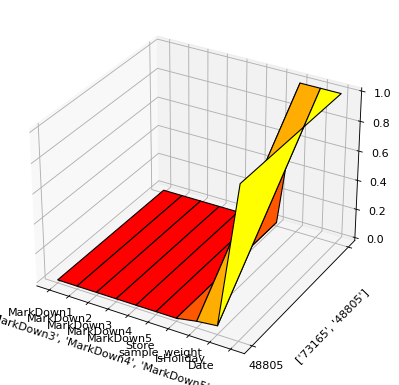

In [39]:
result.plot()

In [40]:
result.data()

{'Dept': {'73165': 0.0, '48805': 0.0},
 'MarkDown1': {'73165': 0.0, '48805': 0.0},
 'MarkDown2': {'73165': 0.0, '48805': 0.0},
 'MarkDown3': {'73165': 0.0, '48805': 0.0},
 'MarkDown4': {'73165': 0.0, '48805': 0.0},
 'MarkDown5': {'73165': 0.0, '48805': 0.0024520653},
 'Store': {'73165': 0.0, '48805': 0.0052142237},
 'sample_weight': {'73165': 0.0242297749, '48805': 1.0},
 'IsHoliday': {'73165': 0.0389024862, '48805': 1.0},
 'Date': {'73165': 1.0, '48805': 1.0}}

In [41]:
result = interpretation.get_explainer_result(
    SegmentPerformanceExplainer.explainer_id()
)

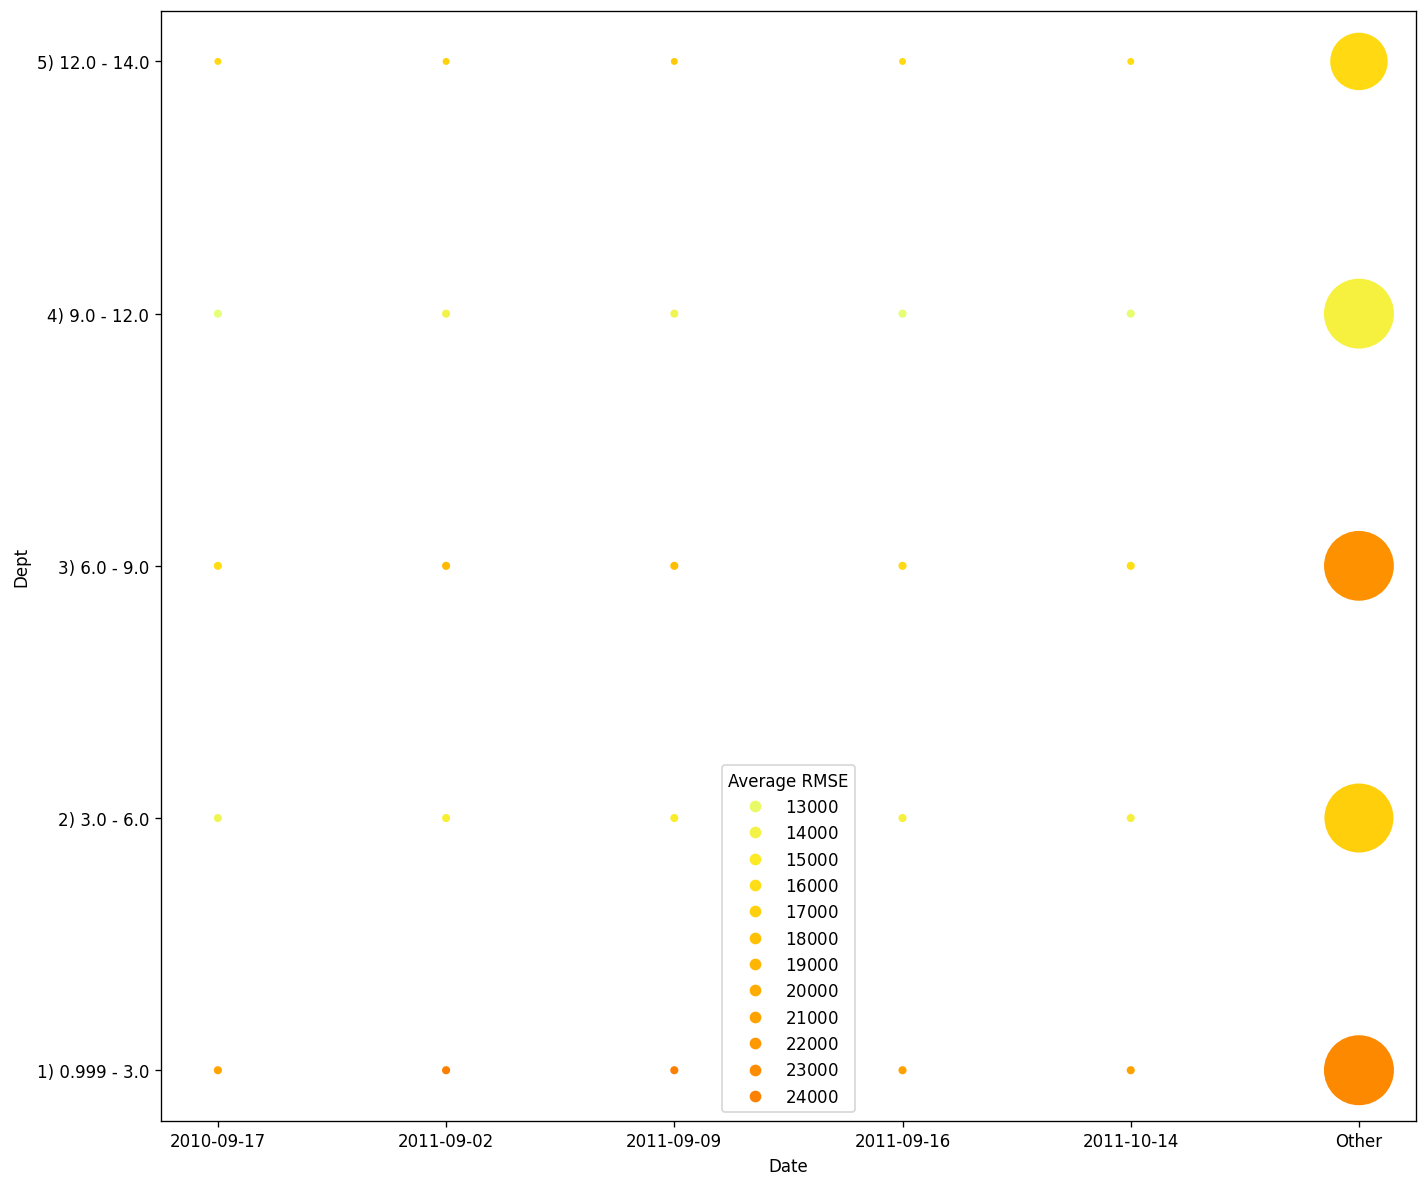

<Figure size 640x480 with 0 Axes>

In [42]:
result.plot()

In [43]:
result.data()

<Frame#7f736308d600 339x6>

In [44]:
result = interpretation.get_explainer_result(
    BacktestingExplainer.explainer_id()
)

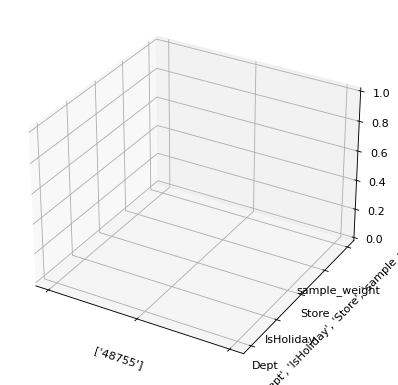

In [45]:
result.plot()

In [46]:
result.data()

{'48755': {'Dept': 0.0,
  'IsHoliday': 0.0,
  'Store': 0.0,
  'sample_weight': 0.3120111525,
  'Date': 1.0}}

## Calibration Score explainer

Calibration Score explainer requires **classification** (in contrast to the explainers which were run in the previous section to explain a **regression** problem).

In [47]:
# run the interpretation
interpretation = interpret.run_interpretation(
    dataset=m_dataset_handle,
    model=m_model_handle,
    target_col=m_target_col,
    # schedule for run all MV explainers + specify parameters they need
    explainers=[
        commons.ExplainerToRun(
            explainer_id=CalibrationScoreExplainer.explainer_id(),
            params={
                CalibrationScoreExplainer.PARAM_WORKER: DAI_WORKER_CONNECTION.key,
            },
        ),
    ],
    results_location="results-calibration-score",
)

# HINT: Calibration Score explainer will be run later as it requires a CLASSIFICATION experiment

2023/09/26 17:39:30 # DEBUG Save Calibration Score: Calibration Score - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:39:30 # WARNING Singleton MVClient already initialized, ignoring: args=(), kwargs={'data_folder': 'results-calibration-score/h2o-sonar/mli_experiment_ff0c6f6e-cdca-4098-bf85-aa8584955177/tmp'} - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:296
2023/09/26 17:39:30 # DEBUG Selected database: test-db - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:255
2023/09/26 17:39:30 # INFO Initialize MVDatabase: test-db
2023/09/26 17:39:30 # DEBUG SQLDatabase: results-drift/h2o-sonar/mli_experiment_ea02c00c-8cb5-4596-bde0-1d602a862c1e/tmp/test.sql_db.sqlite - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:187
2023/09/26 17:39:30 # DEBUG ObjectStorage: results-drift/h2o-sonar/mli_experiment_ea

A service ('Driverless AI') is running on localhost:12345 and it is accessible


2023/09/26 17:39:30 # INFO Adding connection to Driverless AI server 'http://localhost:12345' for user 'h2oai'
2023/09/26 17:39:30 # DEBUG Save credentials: DriverlessCredentials(address='http://localhost:12345', username='h2oai') - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_cache.py:33
2023/09/26 17:39:30 # DEBUG Platform with address 'http://localhost:12345' for user 'h2oai' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:234
2023/09/26 17:39:32 # DEBUG Worker set: <h2o_mv.platforms.driverless.platform.DriverlessPlatform object at 0x7f7363f8a430> - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_client.py:331
2023/09/26 17:39:32 # INFO Connection for <class 'h2o_mv.platforms.driverless.platform.DriverlessPlatform'> not supported
2023/09/26 17:39:32 # DEBUG Import dataset f330f964-ab83-11ed-aa8e-a0cec818dc16 from Driverless Server http://localhost:1234

INFO - Downloaded 'data/temp/creditcard.csv.1676281872.9771898.csv'


2023/09/26 17:39:33 # DEBUG Import experiment 4b000748-fba7-11ed-8ea4-8c1d96f410ff from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:628
2023/09/26 17:39:34 # DEBUG Import dataset f330f964-ab83-11ed-aa8e-a0cec818dc16 from Driverless Server http://localhost:12345 - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/platforms/driverless/platform.py:454


INFO - Downloaded 'data/temp/creditcard.csv.1676281872.9771898.csv'


2023/09/26 17:39:35 # DEBUG Dataset with platform_obj_key 'f330f964-ab83-11ed-aa8e-a0cec818dc16' already in DB - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/databases/sql_db.py:314
2023/09/26 17:39:35 # DEBUG Folder data/temp/8db7fd2a-ceb2-411b-ab34/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69


INFO - Downloaded 'data/temp/8db7fd2a-ceb2-411b-ab34/h2oai_experiment_summary_4b000748-fba7-11ed-8ea4-8c1d96f410ff.zip'


2023/09/26 17:39:35 # DEBUG Folder data/temp/8db7fd2a-ceb2-411b-ab34/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:39:35 # DEBUG Save Calibration Score: Calibration Score - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:39:35 # DEBUG Folder data/temp/mvt-f7cb0574-2afb-4899-9ff5-3ce2e2cb6087/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:69
2023/09/26 17:39:35 # DEBUG Folder data/artifacts/mvt-f7cb0574-2afb-4899-9ff5-3ce2e2cb6087/ created - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:82
2023/09/26 17:39:36 # INFO Calibration Score 'Calibration Score': Running


Complete


2023/09/26 17:39:40 # INFO Calibration Score 'Calibration Score': Completed
2023/09/26 17:39:40 # DEBUG Save Calibration Score: Calibration Score - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:531
2023/09/26 17:39:40 # DEBUG Folder data/temp/mvt-f7cb0574-2afb-4899-9ff5-3ce2e2cb6087/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227
2023/09/26 17:39:40 # DEBUG Folder data/artifacts/mvt-f7cb0574-2afb-4899-9ff5-3ce2e2cb6087/ deleted - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/utils.py:227


In [48]:
# open interpretation HTML report in web browser
webbrowser.open(interpretation.result.get_html_report_location())

True

In [49]:
result = interpretation.get_explainer_result(
    CalibrationScoreExplainer.explainer_id()
)

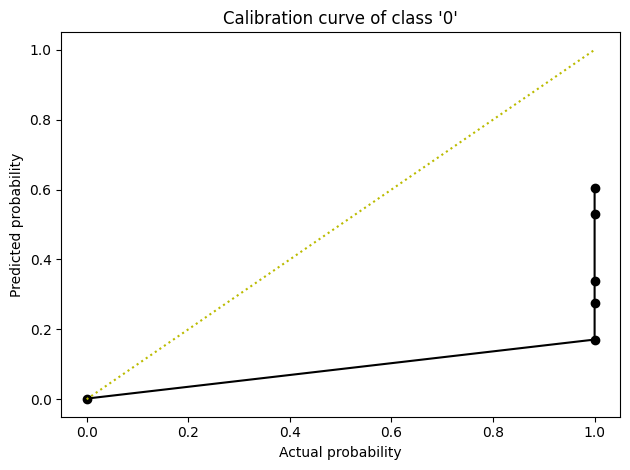

<Figure size 640x480 with 0 Axes>

In [50]:
result.plot()

In [51]:
result.data()

{'classes_labels': ['0', '1', '2', '3', '4', '5', '6'],
 'classes_legends': {'0': 'EDUCATION.0',
  '1': 'EDUCATION.1',
  '2': 'EDUCATION.2',
  '3': 'EDUCATION.3',
  '4': 'EDUCATION.4',
  '5': 'EDUCATION.5',
  '6': 'EDUCATION.6'},
 'plots_paths': ['results-calibration-score/h2o-sonar/mli_experiment_ff0c6f6e-cdca-4098-bf85-aa8584955177/explainer_h2o_sonar_explainers_calibration_score_explainer_CalibrationScoreExplainer_74573bc7-16c5-487e-a565-fa001c02eac1/work/calibration_curve_0.png',
  'results-calibration-score/h2o-sonar/mli_experiment_ff0c6f6e-cdca-4098-bf85-aa8584955177/explainer_h2o_sonar_explainers_calibration_score_explainer_CalibrationScoreExplainer_74573bc7-16c5-487e-a565-fa001c02eac1/work/calibration_curve_1.png',
  'results-calibration-score/h2o-sonar/mli_experiment_ff0c6f6e-cdca-4098-bf85-aa8584955177/explainer_h2o_sonar_explainers_calibration_score_explainer_CalibrationScoreExplainer_74573bc7-16c5-487e-a565-fa001c02eac1/work/calibration_curve_2.png',
  'results-calibration-

# Interpretation: CLI

In [52]:
# check H2O Sonar command line interface (CLI) help
!h2o-sonar --help

usage: h2o-sonar [-h] [--dataset DATASET] [--target-col TARGET_COL]
                 [--results-location RESULTS_LOCATION] [--model MODEL]
                 [--validset VALIDSET] [--testset TESTSET]
                 [--use_raw-features USE_RAW_FEATURES]
                 [--weight-col WEIGHT_COL] [--drop-cols DROP_COLS]
                 [--sample-num-rows SAMPLE_NUM_ROWS]
                 [--used-features USED_FEATURES] [--model-type {pickle,mojo}]
                 [--explainer EXPLAINER] [--explainers EXPLAINERS]
                 [--all-explainers] [--explainers-pars EXPLAINERS_PARS]
                 [--config-path CONFIG_PATH] [--config-type CONFIG_TYPE]
                 [--config-value CONFIG_VALUE]
                 [--encryption-key ENCRYPTION_KEY] [-d]
                 [--args-as-json-location ARGS_AS_JSON_LOCATION]
                 [--log-level {error,warning,info,debug}]
                 action entity

H2O Sonar Python library for Responsible AI.

H2O Sonar is Python package that 

In [53]:
# list explainers
!h2o-sonar list explainers

{
  "explainers": [
    "h2o_sonar.explainers.fi_naive_shapley_explainer.NaiveShapleyMojoFeatureImportanceExplainer",
    "h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer",
    "h2o_sonar.explainers.dt_surrogate_explainer.DecisionTreeSurrogateExplainer",
    "h2o_sonar.explainers.pd_ice_explainer.PdIceExplainer",
    "h2o_sonar.explainers.dia_explainer.DiaExplainer",
    "h2o_sonar.explainers.transformed_fi_shapley_explainer.ShapleyMojoTransformedFeatureImportanceExplainer",
    "h2o_sonar.explainers.residual_dt_surrogate_explainer.ResidualDecisionTreeSurrogateExplainer",
    "h2o_sonar.explainers.residual_pd_ice_explainer.ResidualPdIceExplainer",
    "h2o_sonar.explainers.fi_kernel_shap_explainer.KernelShapFeatureImportanceExplainer",
    "h2o_sonar.explainers.pd_2_features_explainer.PdFor2FeaturesExplainer",
    "h2o_sonar.explainers.friedman_h_statistic_explainer.FriedmanHStatisticExplainer",
    "h2o_sonar.explainers.morris_sa_explainer.MorrisSensitivityAnalysis

## Run Drift Detection explainer using CLI

In [54]:
primary_dataset_path

'../../data/creditcard.csv'

In [55]:
secondary_dataset_path

'/tmp/secondary_dataset.csv'

In [56]:
# run Drift Detection explainer
!h2o-sonar run interpretation \
  --dataset {primary_dataset_path} \
  --testset {secondary_dataset_path} \
  --target-col "default payment next month" \
  --explainers h2o_sonar.explainers.drift_explainer.DriftDetectionExplainer \
  --results-location results-drift-cli 

Stratified/random sampler: loading the original dataset '../../data/creditcard.csv' for sampling...
Stratified/random sampler:   -> did NO sampling as the sampling limit is smaller than the number of rows in the dataset: 10000 <= 25000
Stratified/random sampler: loading the original dataset '/tmp/secondary_dataset.csv' for sampling...
Stratified/random sampler:   -> did NO sampling as the sampling limit is smaller than the number of rows in the dataset: 500 <= 25000
2023/09/26 17:39:47 # DEBUG H2O Model Validation LogLevel: DEBUG - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/logging.py:97
2023/09/26 17:39:48 # WARNING IoC/DI: No implementations found for >>IMVDatabase<< - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/ioc.py:35
2023/09/26 17:39:48 # ERROR Can't save test Drift Detection: no database connection - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:529
2023/09/26 17:39:48 

# Use CLI to run H2O MV based explainers

Use command line interface to run H2O MV based explainers which depend on Driverless AI.

In [57]:
# configure H2O Sonar by adding Driverless AI connection to the configuration
h2o_sonar_config_path = "/tmp/h2o-sonar-config.json"

# secret key to encrypt sensitive fields in the configuration
encryption_key = "my-demo-3ncr1pt10n-key"

# custom Driverless AI server connection ID
dai_connection_key = "demo-dai-connection"

# initialize configuration file with the DEFAULT H2O Sonar configuration
!h2o-sonar show config > {h2o_sonar_config_path}

In [58]:
# verify the configuration content
!h2o-sonar show config \
  --config-path {h2o_sonar_config_path} \
  --encryption-key {encryption_key}

{
  "h2o_host": "localhost",
  "h2o_port": 12349,
  "h2o_auto_start": true,
  "h2o_min_mem_size": "2G",
  "h2o_max_mem_size": "4G",
  "custom_explainers": [],
  "look_and_feel": "h2o_sonar",
  "per_explainer_logger": true,
  "create_html_representations": true,
  "connections": [],
  "licenses": []
}


In [59]:
!h2o-sonar add config \
  --config-type CONNECTION \
  --config-path "/tmp/h2o-sonar-config.json" \
  --encryption-key "my-demo-3ncr1pt10n-key" \
  --config-value "{\"key\": \"demo-dai-connection\", \"connection_type\": \"DRIVERLESS_AI\", \"name\": \"Local Driverless AI server\", \"description\": \"Driverless AI server running on the localhost.\", \"auth_server_url\": \"\", \"server_url\": \"http://localhost:12345\", \"realm_name\": \"\", \"client_id\": \"\", \"token\": \"\", \"username\": \"h2oai\", \"password\": \"h2oai\"}"


In [60]:
# verify the configuration content
!h2o-sonar show config \
  --config-path {h2o_sonar_config_path} \
  --encryption-key {encryption_key}

{
  "h2o_host": "localhost",
  "h2o_port": 12349,
  "h2o_auto_start": true,
  "h2o_min_mem_size": "2G",
  "h2o_max_mem_size": "4G",
  "custom_explainers": [],
  "look_and_feel": "h2o_sonar",
  "per_explainer_logger": true,
  "create_html_representations": true,
  "connections": [
    {
      "key": "demo-dai-connection",
      "connection_type": "DRIVERLESS_AI",
      "name": "Local Driverless AI server",
      "description": "Driverless AI server running on the localhost.",
      "auth_server_url": "",
      "environment_url": "",
      "server_url": "http://localhost:12345",
      "server_id": "",
      "realm_name": "",
      "client_id": "",
      "token": "",
      "token_use_type": "",
      "username": "h2oai",
      "password": "h2oai"
    }
  ],
  "licenses": []
}


In [61]:
# note that the configuration is ENCRYPTED on the filesystem and DECRYPTED in memory
!cat {h2o_sonar_config_path}

{
    "h2o_host": "localhost",
    "h2o_port": 12349,
    "h2o_auto_start": true,
    "h2o_min_mem_size": "2G",
    "h2o_max_mem_size": "4G",
    "custom_explainers": [],
    "look_and_feel": "h2o_sonar",
    "per_explainer_logger": true,
    "create_html_representations": true,
    "connections": [
        {
            "key": "demo-dai-connection",
            "connection_type": "DRIVERLESS_AI",
            "name": "Local Driverless AI server",
            "description": "Driverless AI server running on the localhost.",
            "auth_server_url": "",
            "environment_url": "",
            "server_url": "http://localhost:12345",
            "server_id": "",
            "realm_name": "",
            "client_id": "",
            "token": {
                "encrypted": ""
            },
            "token_use_type": "",
            "username": "h2oai",
            "password": {
                "encrypted": "gAAAAABlEvtKI_IBN3Jppr5b4bJxBxJwFOzLWlW2vVF3z_SGQL9f9fFX9PIAuAibmZGnC

In [62]:
# if there are many CLI arguments and explainer parameters,
# then it is convenient to prepare H2O Sonar arguments as JSon
run_interpretation_args_path = "/tmp/run_interpretation_args.json"

run_interpretation_args = {
    "model": str(ts_model_handle),
    "dataset": str(ts_dataset_handle),
    "testset": str(ts_testset_handle),
    "target_col": ts_target_col,
    "explainers": [
        {
            "id": BacktestingExplainer.explainer_id(),
            "params": {
                "worker_connection_key": dai_connection_key,
                "time_col": "Date",
            },
            
        },
        {
            "id": SizeDependencyExplainer.explainer_id(),
            "params": {
                "worker_connection_key": dai_connection_key,
                "time_col": "Date"
            }
        },
        {
            "id": SegmentPerformanceExplainer.explainer_id(),
            "params": {
                "worker_connection_key": dai_connection_key,
            }
        },
    ]
}

# save interpretation arguments to a JSon file
with open(run_interpretation_args_path, "w") as f:
    json.dump(run_interpretation_args, f)

In [63]:
!cat {run_interpretation_args_path}

{"model": "resource:connection:0d860575-9d4b-46e5-9870-97ebd73780a1:key:b78cb888-f658-11ed-9ecf-0242709d15f7", "dataset": "resource:connection:0d860575-9d4b-46e5-9870-97ebd73780a1:key:a407dd4c-f658-11ed-9ecf-0242709d15f7", "testset": "resource:connection:0d860575-9d4b-46e5-9870-97ebd73780a1:key:a4077500-f658-11ed-9ecf-0242709d15f7", "target_col": "Weekly_Sales", "explainers": [{"id": "h2o_sonar.explainers.backtesting_explainer.BacktestingExplainer", "params": {"worker_connection_key": "demo-dai-connection", "time_col": "Date"}}, {"id": "h2o_sonar.explainers.size_dependency_explainer.SizeDependencyExplainer", "params": {"worker_connection_key": "demo-dai-connection", "time_col": "Date"}}, {"id": "h2o_sonar.explainers.segment_performance_explainer.SegmentPerformanceExplainer", "params": {"worker_connection_key": "demo-dai-connection"}}]}

In [ ]:
# run the interpretations
!h2o-sonar run interpretation \
  --args-as-json-location {run_interpretation_args_path} \
  --config-path {h2o_sonar_config_path} \
  --encryption-key {encryption_key} \
  --results-location "results-mv-dai-cli"

A service ('Driverless AI') is running on localhost:12345 and it is accessible
2023/09/26 17:39:58 # DEBUG H2O Model Validation LogLevel: DEBUG - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/logging.py:97
2023/09/26 17:39:58 # WARNING IoC/DI: No implementations found for >>IMVDatabase<< - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/ioc.py:35
2023/09/26 17:39:58 # ERROR Can't save test Backtesting: no database connection - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/mv_test.py:529
A service ('Driverless AI') is running on localhost:12345 and it is accessible
2023/09/26 17:39:58 # WARNING IoC/DI: No implementations found for >>IMVDatabase<< - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/core/ioc.py:35
2023/09/26 17:39:58 # ERROR Can't save test Size Dependency: no database connection - /home/dvorka/h/mli/git/h2o-sonar/.venv/lib/python3.8/site-packages/h2o_mv/cor